# Model development
Notebook overview:
- create benchmark model
- error metrics
- build model
- train
- evaluate
- deploy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = '../data/'

In [3]:
nasdaq_train = pd.read_csv('../data/nasdaq_export/train.csv', index_col=0, header=None)
nasdaq_test = pd.read_csv('../data/nasdaq_export/test.csv', index_col=0, header=None)

In [4]:
eurusd_train = pd.read_csv('../data/eurusd_export/train.csv', index_col=0, header=None)
eurusd_test = pd.read_csv('../data/eurusd_export/test.csv', index_col=0, header=None)

# Benchmark
Because the benchmark model is very simple and needed only in this notebook, I will define it here. Simple Moving Average forecasting implementation:

In [5]:
class MA_regressor:
    def __init__(self, N=5):
        self.N = N
    
    def forward(self, price):
        return price[-self.N:].sum() / self.N
    
    def predict(self, data, steps=10):
        data = data[4].values
        predictions = [0] * steps
        for i in range(0,steps):
            predictions[i] = self.forward(np.append(data, predictions[:i]))
        return predictions

In [6]:
sample, steps = 30, 10
benchmark = MA_regressor(15)
y = benchmark.predict(nasdaq_train.iloc[:sample], steps)

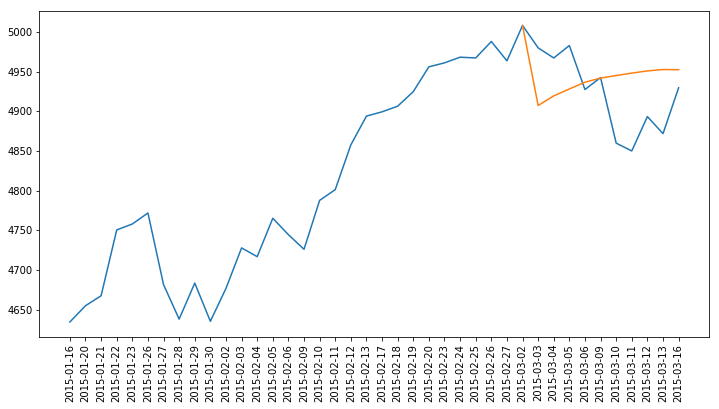

In [7]:
plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
plt.plot(nasdaq_train.iloc[:sample+steps,3])
y_series = nasdaq_train.iloc[sample-1:sample+steps,3].copy()
y_series.iloc[1:] = y
plt.plot(y_series)

# Metrics
The sample prediction is not successfull at all, we need some metric to optimize it.

Because this is an regression problem, we need a loss function describing how far we are from the correct answer.
I propose an $MSE$ metric with a sum reduction:

\begin{equation}
MSE = \frac{1}{2} \left( y - \hat{y} \right)^2
\end{equation}

It will allow us to compute a gradient that moves towards a better solution.

In [8]:
def loss_fn(y_hat, y):
    mse = 0.0
    for a,b in zip(y_hat, y):
        mse += 0.5 * (a - b)**2
    return mse

## Optimizing our benchmark

In [9]:
target = nasdaq_train.iloc[sample:sample+steps,3].values
loss_fn(target, y)

18949.27026399682

In [10]:
def test(in_data, target, w=1):
    loss = [[], []]
    for i in range(2, 90):
        benchmark = MA_regressor(i)
        y = benchmark.predict(in_data, 10)
        loss[0].append(i)
        loss[1].append(loss_fn(target, y) / w)
    return np.array(loss)

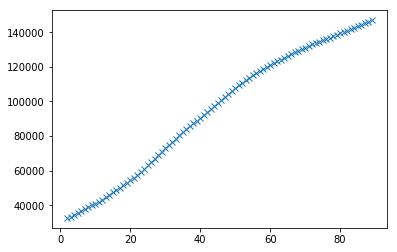

In [11]:
sample = 100
tests = 500

loss = test(nasdaq_train.iloc[:sample], nasdaq_train.iloc[sample:sample+steps,3].values, w=tests)
for offset in range(1,tests,2):
    loss[1] += test(nasdaq_train.iloc[offset:offset+sample],
                 nasdaq_train.iloc[offset+sample:offset+sample+steps,3].values, w=tests)[1]

plt.plot(*loss, 'x')

### Best benchmark model
It is clear that the lowest value of `N = 2` gives the best results over half of the NASDAQ train dataset.

Let's save it as our final benchmark.

In [12]:
benchmark = MA_regressor(N=2)

# LSTM model
Great, now that we know what the performance of our benchmark is, we can start developing a better solution.
Inside `model/model.py` I have created 2 similar LSTM Regression classes:
- LSTMRegeressor - which uses convolution to normalize the data,
- LSTMBatchRegressor - which normalizes the data with trainable 1-D Batch Normalization layer.

I will train both of them and compare the results.

## Data Loader
Before we start we need to create a data loader for our problem.
The best approach is to use a sliding window over the dataset.

In [5]:
import torch
import torch.utils.data

class SlidingWindowDataset(torch.utils.data.IterableDataset):
    def __init__(self, data, window_size):
        super().__init__()
        self.timeseries = data
        self.window = window_size
        self.length = len(self.timeseries)
        
    def __len__(self):
        return self.length - self.window + 1
        
    def __next__(self):
        first = self._start + self._n
        last = self._n + self.window + self._start
        if last > self._end:
            raise StopIteration
        self._n += 1
        return self.timeseries[first:last]
        
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None: # single-process data loading, return the full iterator
            self._start = 0
            self._end = self.length
        else: # split if inside a worker process
            per_worker = int(math.ceil(self.length / float(worker_info.num_workers)))
            worker_id = worker_info.id
            self._start = worker_id * per_worker
            self._end = min(start + per_worker, self.length)
        self._n = 0
        return self

In [6]:
ds = SlidingWindowDataset(nasdaq_test.values, 5)
ds_loader = torch.utils.data.DataLoader(ds, batch_size=1)

In [7]:
i = 0
for _ in ds_loader:
    i += 1
i, len(ds_loader)

TypeError: Cannot determine the DataLoader length of a IterableDataset

In [15]:
sample = next(iter(ds_loader))
sample.shape, sample

(torch.Size([4, 5, 9]),
 tensor([[[ 6.5735e+03,  6.5867e+03,  6.3046e+03,  6.3330e+03,  4.5341e+00,
            7.1693e+03,  7.2094e+03, -1.9542e+02,  5.0000e+01],
          [ 6.2785e+03,  6.3552e+03,  6.1902e+03,  6.1929e+03,  1.6473e+00,
            7.1302e+03,  7.1876e+03, -1.4007e+02,  4.2857e+01],
          [ 6.2579e+03,  6.5555e+03,  6.2143e+03,  6.5544e+03,  2.5589e+00,
            7.1072e+03,  7.1649e+03,  3.6144e+02,  3.5714e+01],
          [ 6.4572e+03,  6.5830e+03,  6.3370e+03,  6.5795e+03,  2.4159e+00,
            7.0861e+03,  7.1460e+03,  2.5130e+01,  4.2857e+01],
          [ 6.6168e+03,  6.6842e+03,  6.5292e+03,  6.5845e+03,  2.1991e+00,
            7.0660e+03,  7.1290e+03,  5.0298e+00,  4.2857e+01]],
 
         [[ 6.2785e+03,  6.3552e+03,  6.1902e+03,  6.1929e+03,  1.6473e+00,
            7.1302e+03,  7.1876e+03, -1.4007e+02,  4.2857e+01],
          [ 6.2579e+03,  6.5555e+03,  6.2143e+03,  6.5544e+03,  2.5589e+00,
            7.1072e+03,  7.1649e+03,  3.6144e+02,  3.5714

## Uploading data
We need to store our input files on S3 server.

In [8]:
import os.path
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/stock_forecasting'

role = sagemaker.get_execution_role()

In [6]:
in_data = {}
for directory in ['nasdaq_export', 'eurusd_export']:
    in_data.update({directory: sagemaker_session.upload_data(path=os.path.join(data_dir,directory), bucket=bucket, key_prefix=os.path.join(prefix,directory))})
in_data

{'nasdaq_export': 's3://sagemaker-us-east-1-236375122127/sagemaker/stock_forecasting/nasdaq_export',
 'eurusd_export': 's3://sagemaker-us-east-1-236375122127/sagemaker/stock_forecasting/eurusd_export'}

## Training
Before we run training job let's make sure that everything works as expected.

In [9]:
import torch
import torch.utils.data

import model.model as mdl
import model.train as trn

In [10]:
def get_train_data_loader(batch_size, sliding_window, training_dir):
    train_data = pd.read_csv(os.path.join(training_dir, "train.csv"), index_col=0, header=None)
    train_ds = mdl.SlidingWindowDataset(train_data.values, sliding_window)
    return torch.utils.data.DataLoader(train_ds, batch_size=batch_size)

In [11]:
model = mdl.LSTMRegressor(input_size=10, input_channels=9, c_filters=2, c_kernel_size=3, lstm_layers=2, lstm_hidden=1, dropout=0.2, output_size=1)
model = model.double()

In [12]:
train_loader = get_train_data_loader(4, 10+1, os.path.join(data_dir,'nasdaq_export'))
# Train the model.
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss(reduction='sum')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
trn.train(model, 1, train_loader, 5, optimizer, loss_fn, device)

TypeError: Cannot determine the DataLoader length of a IterableDataset

### Run training
After passing test, it is time to run training job on SageMaker.

In [20]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="model",
                    role=role,
                    framework_version='1.2.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 14,
                    })

In [21]:
estimator.fit({'training': in_data['nasdaq_export']})

2020-01-28 16:39:30 Starting - Starting the training job...
2020-01-28 16:39:32 Starting - Launching requested ML instances......
2020-01-28 16:40:38 Starting - Preparing the instances for training.........
2020-01-28 16:42:06 Downloading - Downloading input data...
2020-01-28 16:43:01 Training - Downloading the training image.............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-28 16:45:05,941 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-28 16:45:05,967 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-28 16:45:05,968 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-28 16:45:06,253 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-01-28 16:45:06,253 sagemaker-containers INFO     Generating setup.cfg
2020-01-28 16:45:06,253 sagemake

UnexpectedStatusException: Error for Training job pytorch-training-2020-01-28-16-39-30-183: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python -m train --epochs 14"
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/ml/code/train.py", line 115, in <module>
    train(model, args.output_size, train_loader, args.epochs, optimizer, loss_fn, device)
  File "/opt/ml/code/train.py", line 31, in train
    for batch in train_loader:         
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 346, in __next__
    data = self.dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 35, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 63, in default_collate
    raise TypeError(default_collate_err_msg_fo

## Testing
Deploy, provide test data, evaluate.

In [ ]:
predictor = estimator.deploy(instance_type='ml.p2.xlarge', initial_instance_count=1)

## Clean-up
Once finished, we remove the endpoint. I prefer to use SageMaker console for this task, but here is the code.

In [ ]:
estimator.delete_endpoint()

# Deployment for web app
Realtime predictor is suggested here but it may change.

In [73]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.2.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

NameError: name 'estimator' is not defined

In [ ]:
predictor.endpoint